In [ ]:
!pip install scikit-learn
!pip install scipy

In [4]:
from sklearn.datasets import fetch_kddcup99

In [1]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, udf, array, min as smin, lit, count, isnan, when, sum as ssum
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Creating a Spark session

In [2]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("k-meaner") \
    .config("spark.executor.memory", "1024m") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

#clear old data if rerunning
spark.catalog.clearCache() 
for (id, rdd) in sc._jsc.getPersistentRDDs().items():
    rdd.unpersist()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/07/11 07:00:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading the `kddcup99` dataset

In [5]:
kdd = spark.createDataFrame(fetch_kddcup99(as_frame=True)["frame"])

/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


# Pre-processing
We remove the first three “categorical” columns, and keep only the numerical ones. Then we rescale those to a [0, 1] range. Also, we remove two columns that happen to be all zeros. After all, this shouldn’t affect the clustering afterwards.

In [6]:
kdd.printSchema()

root
 |-- duration: long (nullable = true)
 |-- protocol_type: binary (nullable = true)
 |-- service: binary (nullable = true)
 |-- flag: binary (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- land: long (nullable = true)
 |-- wrong_fragment: long (nullable = true)
 |-- urgent: long (nullable = true)
 |-- hot: long (nullable = true)
 |-- num_failed_logins: long (nullable = true)
 |-- logged_in: long (nullable = true)
 |-- num_compromised: long (nullable = true)
 |-- root_shell: long (nullable = true)
 |-- su_attempted: long (nullable = true)
 |-- num_root: long (nullable = true)
 |-- num_file_creations: long (nullable = true)
 |-- num_shells: long (nullable = true)
 |-- num_access_files: long (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: long (nullable = true)
 |-- count: long (nullable = true)
 |-- srv_count: long (nullable = true)
 |-- serror_rate: d

In [7]:
kdd = kdd.drop("protocol_type")
kdd = kdd.drop("service") 
kdd = kdd.drop("flag")

kdd.createOrReplaceTempView("kdd_table")

for c in kdd.columns:
    try:
        limits = spark.sql("SELECT min(" + c + "), max(" + c + ") FROM kdd_table").collect()
        #mx = kdd.groupby().max(c).first().asDict()['max('+c+')']
        #mn = kdd.groupby().min(c).first().asDict()['min('+c+')']
        mn, mx = limits[0][0], limits[0][1]
        
        if mn==mx:
            continue
        
        
        kdd = kdd.withColumn(c, (col(c)-mn)/(mx-mn) )
        
        #print(limits[0][0], limits[0][1])
    except Exception as e:
        print(e)

#kdd.take(1)
#help(kdd)

#for c in kdd.columns:
#    kdd.schema[c].nullable=False

#kdd = spark.createDataFrame(kdd.rdd, kdd.schema)
kdd = kdd.persist()
#kdd.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in kdd.columns if c not in ["labels"]]).show()

unsupported operand type(s) for -: 'bytearray' and 'bytearray'


In [8]:
kdd.printSchema()

#kdd.select(array([c for c in kdd.columns if c!="labels"])).take(1)[0][0]

root
 |-- duration: double (nullable = true)
 |-- src_bytes: double (nullable = true)
 |-- dst_bytes: double (nullable = true)
 |-- land: double (nullable = true)
 |-- wrong_fragment: double (nullable = true)
 |-- urgent: double (nullable = true)
 |-- hot: double (nullable = true)
 |-- num_failed_logins: double (nullable = true)
 |-- logged_in: double (nullable = true)
 |-- num_compromised: double (nullable = true)
 |-- root_shell: double (nullable = true)
 |-- su_attempted: double (nullable = true)
 |-- num_root: double (nullable = true)
 |-- num_file_creations: double (nullable = true)
 |-- num_shells: double (nullable = true)
 |-- num_access_files: double (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: double (nullable = true)
 |-- count: double (nullable = true)
 |-- srv_count: double (nullable = true)
 |-- serror_rate: double (nullable = true)
 |-- srv_serror_rate: double (nullable = true)
 |-- rerror

assembler = VectorAssembler(inputCols=[c for c in kdd.columns if c not in ["protocol_type", "service", "flag", "labels"]], outputCol="features")
assembled_df = assembler.transform(kdd)

scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(assembled_df)
normalized_data = scaler_model.transform(assembled_df)

### Plotting the distribution of attack types…

In [9]:
"""targets = kdd[1]

attacks, counts = np.unique(targets, return_counts=True)
ypos = np.arange(len(attacks))

attack_sort = np.argsort(counts)
attacks = attacks[attack_sort]
counts = counts[attack_sort]
"""
res = spark.sql("SELECT labels, count(1) FROM kdd_table GROUP BY labels").collect()

In [10]:
attacks = np.array([r[0] for r in res])
counts = np.array([r[1] for r in res])
attack_sort = np.argsort(counts)
attacks = attacks[attack_sort]
counts = counts[attack_sort]

ypos = np.arange(len(attacks))

/tmp/ipykernel_1449/2946778956.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  attacks = np.array([r[0] for r in res])


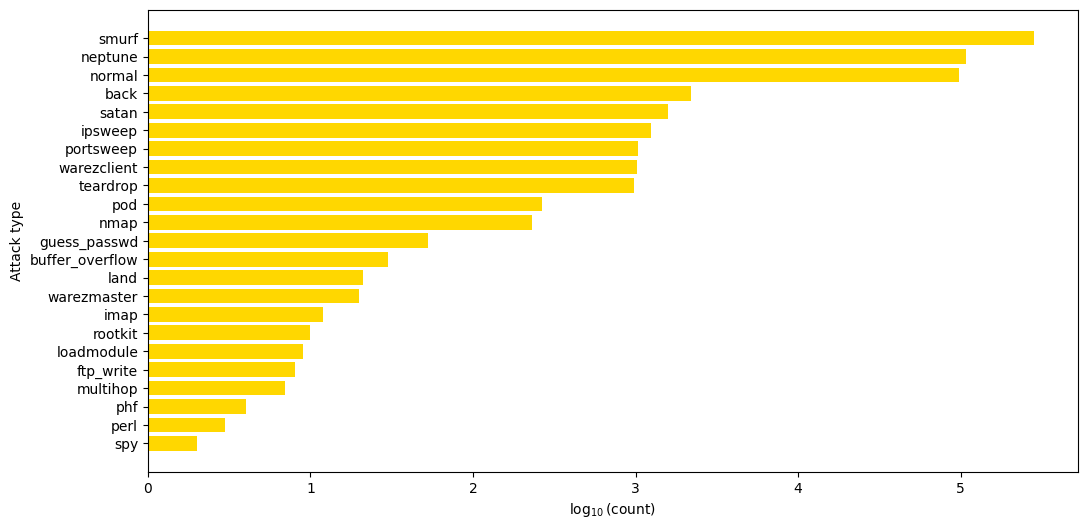

In [11]:
plt.figure(figsize=(12, 6))
plt.barh(ypos, np.log10(counts), facecolor="gold")
plt.yticks(ypos, labels=[a.decode("utf-8")[0:-1] for a in attacks])
plt.xlabel(r"$\log_{10}(\mathrm{count})$")
plt.ylabel("Attack type")
plt.show()

## Start on k-means basic algo

In [12]:
index_udf = udf(lambda row:attacks.tolist().index(row) )
kdd = kdd.withColumn("labels", index_udf(col("labels")).cast("int"))

In [13]:
ignored_cols = ["labels", "centr", "cost", "p", "w"]

In [14]:
kdd = kdd.withColumn("centr", lit(-1))
kdd = kdd.withColumn("cost", lit(0.))
kdd = kdd.withColumn("p", lit(0.))
ncols = len([c in kdd.columns if c not in ignored_cols])

In [15]:
kdd

DataFrame[duration: double, src_bytes: double, dst_bytes: double, land: double, wrong_fragment: double, urgent: double, hot: double, num_failed_logins: double, logged_in: double, num_compromised: double, root_shell: double, su_attempted: double, num_root: double, num_file_creations: double, num_shells: double, num_access_files: double, num_outbound_cmds: bigint, is_host_login: bigint, is_guest_login: double, count: double, srv_count: double, serror_rate: double, srv_serror_rate: double, rerror_rate: double, srv_rerror_rate: double, same_srv_rate: double, diff_srv_rate: double, srv_diff_host_rate: double, dst_host_count: double, dst_host_srv_count: double, dst_host_same_srv_rate: double, dst_host_diff_srv_rate: double, dst_host_same_src_port_rate: double, dst_host_srv_diff_host_rate: double, dst_host_serror_rate: double, dst_host_srv_serror_rate: double, dst_host_rerror_rate: double, dst_host_srv_rerror_rate: double, labels: int, centr: int, cost: double, p: double]

In [16]:
def dist(x,y):
    try:
        #return (((np.array(x)-y)**2).sum())**0.5
        return np.linalg.norm(np.array(x)-np.array(y))
    except Exception as e:
        print(e)
        return ncols

def argcomp(comp,func, arr, *params):
    res = [func(arr[i], *params) for i in range(len(arr))]
    #print(res)
    return res.index(comp(res))

#udist=udf(dist, FloatType())

#distance_udf = udf(lambda x,y:  np.linalg.norm(x-y), FloatType())

In [36]:
###################################### actual k-means 
def kmeans(data, centers, max_iter=10, weighted=False, local_centr=False):
    count = 0
    if weighted and "w" not in ignored_cols:
        ignored_cols.append("w")
    
    #print(ignored_cols)
    
    while True:
        if local_centr:
            cc = centers
            local_centr = False
        else:
            cc = centers.collect()
        #print(cc)
        
        argmindist_udf = udf(lambda row: argcomp(min,dist,cc,row), IntegerType())
        
        data = data.withColumn("centr", argmindist_udf(array([c for c in data.columns if c not in ignored_cols])))
        
        if not weighted:
            newcenters = data.groupBy("centr").mean().select(*[col("avg("+c+")") for c in data.columns if c not in ignored_cols])
        else:
            #newcenters = data.groupBy("centr").agg(ssum(array([c for c in data.columns if c not in ignored_cols]) * col("w"))/ssum(col("w")))
            newcenters = data.rdd.map(
                lambda x: (x["centr"],(x[[c for c in data.columns if c not in ignored_cols]],x["w"]))
            ).reduceByKey(
                lambda x,y: ((x[0]*x[1]+y[0]*y[1])/(x[1]+y[1]), x[1]+y[1])
            ).map(lambda x: x[1][0]).collect()
        
        centers = newcenters
        
        count+=1
        if count>max_iter:#(newcenters-centers).mean() < 0.01:
            break
            
    
    return data, centers

In [ ]:
centers = pd.DataFrame(np.random.random(size=(len(attacks), ncols)))
centers = spark.createDataFrame(centers)

In [ ]:
finaldata, newcenters = kmeans(kdd, centers)

In [ ]:
newcenters.collect()

In [ ]:
finaldata.take(1)

##### check results
#print(d, len(d))
mat = [[0 for i in range(4)] for j in range(4)]
for i in range(4):
    for j in range(4):
        for k in range(len(d)):
            mat[i][j] += ((d[k]["labels"] == i) and (d[k]["centr"] == j))
mat

## K-means||

In [60]:
def kmeans_parallel(data, k, l):
    centr = data.select(array([c for c in data.columns if c not in ignored_cols])).rdd.takeSample(True,2)
    #define get_cost using udf on min(dist(row,centr[i]))
    get_cost = udf(lambda row: str(min([dist(row, cen)**2 for cen in centr])))
    
    data = data.withColumn("cost", get_cost(array([c for c in data.columns if c not in ignored_cols])).cast("double"))
    
    cost = data.select("cost").groupBy().sum().collect()[0][0]
    
    for i in range(int(np.log(cost))):
        #re-define get_cost using udf on min(dist(row,centr[i]))
        get_cost = udf(lambda row: str(min([dist(row, cen)**2 for cen in centr])))
        data = data.withColumn("cost", get_cost(array([c for c in data.columns if c not in ignored_cols])).cast("double"))
        #data = data.orderBy("cost")
        cost = data.select("cost").groupBy().sum().collect()[0][0]
        #print(cost, type(cost), cost.__repr__(), cost.__str__())
        #data.withColumn("p", data.select("cost").cumsum()/cost)
        
        #data = data.withColumn('p', ssum('cost').over(Window.orderBy('cost')))
        data = data.withColumn("p", udf(lambda row: np.random.random())(col("cost")))
        #for j in range(l):
        centr.extend( data.where( data["cost"] * l > cost * data["p"]).select(array([c for c in data.columns if c not in ignored_cols])).collect() )
    
    ## search for possible identical centroids
    
    if len(centr) > k: 
        #get weights
        testdata, _ = kmeans(data, centr, max_iter=0, local_centr=True)
        counts = testdata.groupBy("centr").count().collect()
        counts = sorted(counts)
        
        #parallelize the centroid dataset
        cdata = spark.createDataFrame(pd.DataFrame([[*centr[i][0], counts[i][1]] for i in range(len(centr))], columns=(0,1,"w")))
        cdata = cdata.withColumn("w", col("w").cast("double"))
        
        ## basically kmeans++ on the centroids as init for the weighted k-means
        c = [centr[np.random.randint(len(centr))]]
        for i in range(k-1):
            costs = [min([dist(centr[j], c[k])**2 for k in range(len(c))]) for j in range(len(centr))]
            p = np.cumsum(costs)
            p/= p[-1]
            c.append(centr[(p>np.random.random()).tolist().index(True)])
        
        
        _, centr = kmeans(cdata, c, local_centr=True, weighted=False)
        centr = centr.collect()
    return centr

In [19]:
testdata = np.random.random(size=(300, 2))*2-1
testdata[testdata>=0]+=1
testdata[testdata<0]-=1
testdata

array([[ 1.18946178, -1.52111456],
       [ 1.44214084,  1.42465786],
       [-1.33776911, -1.30446645],
       [-1.6671827 ,  1.20488231],
       [-1.94315469,  1.47622494],
       [ 1.34337418,  1.7136656 ],
       [-1.95799365, -1.64670533],
       [-1.75184475, -1.18446244],
       [ 1.64118196,  1.47643712],
       [ 1.2442104 ,  1.47349929],
       [ 1.31294382,  1.97316066],
       [-1.40211217,  1.95587461],
       [ 1.51510826, -1.72672348],
       [ 1.88706578,  1.43376629],
       [ 1.81640447,  1.24690204],
       [ 1.16269445,  1.67897831],
       [ 1.7746885 ,  1.12369617],
       [-1.25548775, -1.57287236],
       [ 1.66516095,  1.44333411],
       [-1.83490093, -1.1344411 ],
       [-1.36728365,  1.63600021],
       [-1.26873427,  1.3623533 ],
       [-1.75623782, -1.24922077],
       [-1.7858631 , -1.26419029],
       [ 1.78240109,  1.24095159],
       [-1.1416934 , -1.50303821],
       [-1.22515177, -1.67705692],
       [ 1.90754976,  1.08287739],
       [-1.12525579,

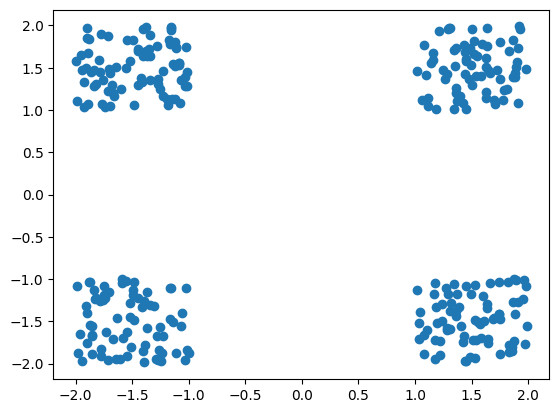

In [20]:
plt.scatter([i[0] for i in testdata], [i[1] for i in testdata])

In [21]:
testdata=spark.createDataFrame(pd.DataFrame(testdata))

In [61]:
c = kmeans_parallel(testdata, 4, 2.5)

['labels', 'centr', 'cost', 'p', 'w']


/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


['labels', 'centr', 'cost', 'p', 'w']


In [ ]:
#c = kmeans_parallel(kdd, 10, 2.5) ## l should be ~ k/log(N*ndim) to allow for an appropriate number of centroids


In [62]:
c

[Row(avg(0)=1.6187640075821632, avg(1)=-1.5236118967107297),
 Row(avg(0)=-1.373764368253357, avg(1)=1.3851888336457037),
 Row(avg(0)=-1.6451007826274182, avg(1)=-1.6982130994047961),
 Row(avg(0)=1.6061583898710896, avg(1)=1.711068155350454)]

In [63]:
data_k, c_k = kmeans(testdata, c, local_centr=True)

['labels', 'centr', 'cost', 'p', 'w']


In [65]:
data_k = data_k.collect()
c_k=c_k.collect()

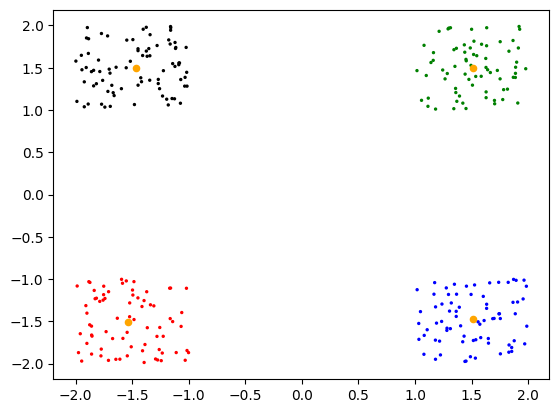

In [73]:
colors=["black", "green", "red", "blue"]
plt.scatter([d[0] for d in data_k], [d[1] for d in data_k], color=[colors[d["centr"]] for d in data_k], s=2)
plt.scatter([d[0] for d in c_k], [d[1] for d in c_k], color="orange", s=20)